<div align="center">
<h1 align="center"><strong>Does size matter?</strong></h1>
  <p align="center">
    Applied Data Analysis (CS-401)
  </p>
</div>

Customers are increasingly relying on **product rating** websites to inform their purchasing decisions. It has been demonstrated that when customers rate a product, they often exhibit a **tendency to be influenced by the previous ratings** of other customers, a phenomenon known as the **_herding effect_**.

Despite this, an unresolved research question revolves around comprehending **how ratings might be impacted by the scale of the vendor**. Utilizing data sourced from beer reviews websites, our objective is to investigate the **connection** between the **size of vendors** (specifically, breweries) and **the perceived quality** of their products.

Through the quantification of brewery size using a **predefined metric** and the **extraction of sentiment** from textual reviews, our aim is to ascertain whether a correlation exists between vendor size and perceived product quality. Additionally, we plan to **explore the behaviors** of diverse consumer bases, considering **temporal dimensions** (how these phenomena have evolved over the years and seasons within the same year) and **spatial dimensions** (how these relationships differ across states and countries).

\begin{equation}
\begin{aligned}
    Size = \alpha N_r + \beta N_b + \gamma N_t
\end{aligned}
\end{equation}

With:
- $N_r = $ number of reviews, 
- $N_b = $ number of beers produced,
- $N_t = $ = number of different types of beer produced.

## **BeerAdvocate**: Project proposal and initial analysis

In [1]:
# Import  libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import os
from datetime import datetime

In [2]:
# Define the data folder paths for BeerAdvocate
DATA_FOLDER_BA = 'data/BeerAdvocate/'

# Define the file paths for the datasets
Beers_DATASET = DATA_FOLDER_BA+"beers.csv"
Users_DATASET = DATA_FOLDER_BA+"users.csv"
Reviews_DATASET = DATA_FOLDER_BA+"reviews_BA.csv"
Breweries_DATASET = DATA_FOLDER_BA+"breweries.csv"

### **Beers**

We starting conducting an analysis on a dataset containing information about beers. The dataset includes the following columns:

- `beer_id`: Identifier for the beer.
- `beer_name`: Name of the beer.
- `brewery_id`: Identifier for the brewery producing the beer.
- `brewery_name`: Name of the brewery.
- `style`: Beer style.
- `nbr_ratings`: Number of ratings received.
- `nbr_reviews`: Number of reviews.
- `avg`: Average rating.
- `ba_score`: BeerAdvocate score.
- `bros_score`: Bros score.
- `abv`: Alcohol by volume.
- `avg_computed`: Computed average rating.
- `zscore`: Z-score.
- `nbr_matched_valid_ratings`: Number of matched valid ratings.
- `avg_matched_valid_ratings`: Average of matched valid ratings.

Our analysis involves the following steps:

- **Filtering Beers with Less than 5 Reviews**: Deleting beers with fewer than 5 reviews, as they may not be characteristic.

- **Handling Missing Values**: Dropping rows with NaN values in the 'nbr_ratings' column.

- **Removing Duplicates**: Dropping duplicate entries based on the 'beer_name' column.

- **Column Selection**: Dropping columns that won't be used in our analysis.

In [25]:
# Read the datasets into Pandas DataFrames
beers = pd.read_csv(Beers_DATASET)
display(beers)

,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,nbr_reviews,avg,ba_score,bros_score,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings
0,166064,Nashe Moskovskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.7,NaN,NaN,0,NaN
1,166065,Nashe Pivovskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,3.8,NaN,NaN,0,NaN
2,166066,Nashe Shakhterskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.8,NaN,NaN,0,NaN
3,166067,Nashe Zhigulevskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.0,NaN,NaN,0,NaN
4,166063,Zhivoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.5,NaN,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280818,19139,Kölsch Ale,885,Summit Station Restaurant & Brewery,Kölsch,3,3,2.71,NaN,NaN,5.0,2.713333,NaN,0,NaN
280819,19140,Nut Brown Ale,885,Summit Station Restaurant & Brewery,English Brown Ale,2,1,3.10,NaN,NaN,5.3,3.250000,NaN,0,NaN
280820,19146,Octoberfest,885,Summit Station Restaurant & Brewery,Märzen / Oktoberfest,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
280821,2805,Scotch Ale,885,Summit Station Restaurant & Brewery,Scotch Ale / Wee Heavy,0,0,NaN,NaN,NaN,7.0,NaN,NaN,0,NaN


In [26]:
# Set a minimum threshold for the number of reviews
MIN_NUMBER_OF_REVIEWS = 5

# Create a filtered copy of the 'beers' DataFrame with a minimum number of reviews
beers_filt = beers.copy(deep=True)
beers_filt = beers_filt[beers_filt['nbr_reviews'] >= MIN_NUMBER_OF_REVIEWS]

# Remove rows with missing values in the 'nbr_reviews' column
beers_filt = beers_filt[beers_filt['nbr_reviews'].notna()]

# Drop duplicate entries based on the 'beer_name' column
beers_filt = beers_filt.drop_duplicates(subset=['beer_name'])

# Calculate the number of duplicate entries based on 'beer_name' and 'beer_id'
dupli_name = np.sum(beers_filt.duplicated(subset=['beer_name']))
dupli_ID = np.sum(beers_filt.duplicated(subset=['beer_id']))

# Drop specific columns from the filtered DataFrame
beers_filt = beers_filt.drop(['zscore', 'nbr_matched_valid_ratings', 'avg_matched_valid_ratings', 'bros_score', 'ba_score'], axis=1)

# Display the filtered DataFrame
display(beers_filt)

# Print the number of duplicate entries for 'beer_name' and 'beer_id'
print(f'Number of duplicate beer name = {dupli_name}')
print(f'Number of duplicate beer ID = {dupli_ID}')


,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,nbr_reviews,avg,abv,avg_computed
25,19827,Legbiter,10093,Strangford Lough Brewing Company Ltd,English Pale Ale,75,59,3.45,4.8,3.439867
26,20841,St. Patrick's Ale,10093,Strangford Lough Brewing Company Ltd,English Pale Ale,8,6,3.86,6.0,3.888750
27,20842,St. Patrick's Best,10093,Strangford Lough Brewing Company Ltd,English Bitter,64,48,3.56,4.2,3.556094
33,825,Caffrey's Irish Ale,297,Thomas Caffrey Brewing Co.,Irish Red Ale,131,82,3.23,3.8,3.286260
44,16371,Belfast Ale,3415,Whitewater Brewing Co,English Pale Ale,21,13,3.69,4.5,3.666667
...,...,...,...,...,...,...,...,...,...,...
280791,67855,Pivotal Porter (Barrel Aged),23640,Twisted Manzanita Ales,American Porter,19,11,3.28,7.5,3.302105
280796,61815,Riverwalk Blonde,23640,Twisted Manzanita Ales,American Blonde Ale,55,20,3.44,6.0,3.476545
280799,61816,Rustic Horizon Red Ale,23640,Twisted Manzanita Ales,American Amber / Red Ale,40,17,3.34,6.8,3.399000
280807,77211,Where There's Smoke,23640,Twisted Manzanita Ales,Smoked Beer,18,5,3.72,7.4,3.536111


Number of duplicate beer name = 0
Number of duplicate beer ID = 0


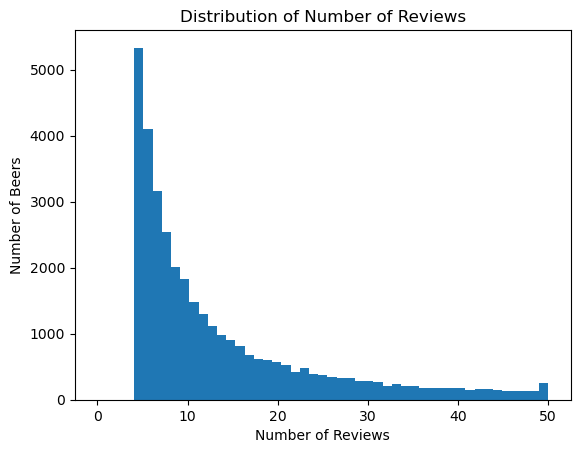

In [27]:
# Plotting a histogram of the distribution of the number of reviews for filtered beers
plt.hist(beers_filt['nbr_reviews'], bins=np.linspace(0, 50, 50))

# Set x and y labels and the title for the plot
plt.xlabel('Number of Reviews')
plt.ylabel('Number of Beers')
plt.title('Distribution of Number of Reviews')

plt.show()

### **Users**

In [28]:
users = pd.read_csv(Users_DATASET)
display(users)

,nbr_ratings,nbr_reviews,user_id,user_name,joined,location
0,7820,465,nmann08.184925,nmann08,1.199704e+09,"United States, Washington"
1,2521,2504,stjamesgate.163714,StJamesGate,1.191838e+09,"United States, New York"
2,1797,1143,mdagnew.19527,mdagnew,1.116410e+09,Northern Ireland
3,31,31,helloloser12345.10867,helloloser12345,1.101380e+09,Northern Ireland
4,604,604,cypressbob.3708,cypressbob,1.069326e+09,Northern Ireland
...,...,...,...,...,...,...
153699,1,1,everman.532342,Everman,1.291115e+09,"United States, California"
153700,1,1,justin0001.352175,Justin0001,1.248343e+09,"United States, California"
153701,1,0,kyungsup.982216,Kyungsup,1.430561e+09,NaN
153702,1,1,joetex.800347,JoeTex,1.400234e+09,"United States, California"


In [29]:
users_filt = users.copy(deep=True)
# Check for duplicates
dupli_name = np.sum(users_filt.duplicated(subset=['user_name']))
dupli_ID = np.sum(users_filt.duplicated(subset=['user_id']))
# Remove users with 0 review and NaN as nb of reviews
users_filt = users_filt[users_filt['nbr_reviews'] >= 1]
users_filt = users_filt[users_filt['nbr_reviews'].notna()]
# Remove Nan in user_id, user_name and user_location
users_filt = users_filt[users_filt['user_id'].notna()]
users_filt = users_filt[users_filt['user_name'].notna()]
users_filt = users_filt[users_filt['location'].notna()]
# Change date type
users_filt['joined'] = users_filt['joined'].apply(lambda x: datetime.utcfromtimestamp(x) if not pd.isna(x) else x)
# Change name of category location into user_location
users_filt.rename(columns={'location': 'user_location'}, inplace = True)
# Display
display(users_filt)
print(f'Number of duplicate user name = {dupli_name}')
print(f'Number of duplicate user ID = {dupli_ID}')
print('Number of NaN by category:')
print(np.sum(users_filt.isna()))



,nbr_ratings,nbr_reviews,user_id,user_name,joined,user_location
0,7820,465,nmann08.184925,nmann08,2008-01-07 11:00:00,"United States, Washington"
1,2521,2504,stjamesgate.163714,StJamesGate,2007-10-08 10:00:00,"United States, New York"
2,1797,1143,mdagnew.19527,mdagnew,2005-05-18 10:00:00,Northern Ireland
3,31,31,helloloser12345.10867,helloloser12345,2004-11-25 11:00:00,Northern Ireland
4,604,604,cypressbob.3708,cypressbob,2003-11-20 11:00:00,Northern Ireland
...,...,...,...,...,...,...
153694,1,1,quaffer83.125656,Quaffer83,2007-03-04 11:00:00,"United States, Michigan"
153699,1,1,everman.532342,Everman,2010-11-30 11:00:00,"United States, California"
153700,1,1,justin0001.352175,Justin0001,2009-07-23 10:00:00,"United States, California"
153702,1,1,joetex.800347,JoeTex,2014-05-16 10:00:00,"United States, California"


Number of duplicate user name = 0
Number of duplicate user ID = 0
Number of NaN by category:
nbr_ratings      0
nbr_reviews      0
user_id          0
user_name        0
joined           0
user_location    0
dtype: int64


### **Breweries**

In [30]:
breweries = pd.read_csv(Breweries_DATASET)
display(breweries)

,id,location,name,nbr_beers
0,39912,Kyrgyzstan,Abdysh-Ata (Абдыш Ата),5
1,39913,Kyrgyzstan,Arpa (АРПА),1
2,39914,Kyrgyzstan,Bear Beer,4
3,39915,Kyrgyzstan,Blonder Pub,4
4,39916,Kyrgyzstan,Kellers Bier,2
...,...,...,...,...
16753,128,Germany,Privatbrauerei Franz Joseph Sailer,6
16754,5023,Aruba,Aruba Brewing,0
16755,1573,"United States, New York",John Harvard’s Brewery & Ale House,491
16756,16186,"United States, North Carolina",Triangle Brewing Company,20


In [31]:
breweries_filt = breweries.copy(deep=True)

dupli_ID = np.sum(breweries_filt.duplicated(subset=['id']))
breweries_filt = breweries_filt[breweries_filt['nbr_beers'] >= 1]
breweries_filt = breweries_filt[breweries_filt.notna()]
breweries_filt = breweries_filt.drop_duplicates(subset='name')
dupli_name = np.sum(breweries_filt.duplicated(subset=['name']))
breweries_filt.rename(columns={'name': 'brewery_name'}, inplace = True)
breweries_filt.rename(columns={'id': 'brewery_id'}, inplace = True)
breweries_filt.rename(columns={'location': 'brewery_location'}, inplace = True)
display(breweries_filt)
print(f'Number of duplicate name = {dupli_name}')
print(f'Number of duplicate ID = {dupli_ID}')
print(np.sum(breweries_filt.isna()))

,brewery_id,brewery_location,brewery_name,nbr_beers
0,39912,Kyrgyzstan,Abdysh-Ata (Абдыш Ата),5
1,39913,Kyrgyzstan,Arpa (АРПА),1
2,39914,Kyrgyzstan,Bear Beer,4
3,39915,Kyrgyzstan,Blonder Pub,4
4,39916,Kyrgyzstan,Kellers Bier,2
...,...,...,...,...
16748,16233,"United States, California",Farmhouse Brewing Co.,4
16751,1613,"United States, Florida",Panama City Brewery & Cafe,5
16753,128,Germany,Privatbrauerei Franz Joseph Sailer,6
16755,1573,"United States, New York",John Harvard’s Brewery & Ale House,491


Number of duplicate name = 0
Number of duplicate ID = 0
brewery_id          0
brewery_location    0
brewery_name        0
nbr_beers           0
dtype: int64


### **Reviews**

We now delve into the BeerAdvocate Reviews dataset, focusing on reviews of various beers. The dataset contains the following columns:

- `beer_name`: Name of the beer.
- `beer_id`: Identifier for the beer.
- `brewery_name`: Name of the brewery producing the beer.
- `brewery_id`: Identifier for the brewery.
- `style`: Beer style.
- `abv`: Alcohol by volume.
- `date`: Timestamp of the review.
- `user_name`: Username of the reviewer.
- `user_id`: Identifier for the user.
- `appearance`: Rating for the beer's appearance.
- `aroma`: Rating for the beer's aroma.
- `palate`: Rating for the beer's palate.
- `taste`: Rating for the beer's taste.
- `overall`: Overall rating.
- `rating`: Overall user rating.
- `text`: Review text.


Our analysis begins with the following initial steps:

1. **Converting Timestamps to Datetime**: We start by converting the 'date' column, which contains timestamps, into the datetime format. This conversion enables us to perform time-based analyses more effectively.

2. **Handling Missing Values**: We address missing values in the dataset by dropping rows with NaN values. This ensures that our analysis is based on complete and reliable data.

3. **Removing Unnecessary Column**: The 'abv' column, representing the alcohol by volume, is not useful for our specific analysis. Consequently, we opt to drop this column to streamline our dataset.

In [3]:
# Importing the 'unescape' function from the 'html' module for text cleaning of html escape characters
try:
    from html import unescape
except:
    !pip install html

# Importing the 'detect' function from the 'langdetect' module for language detection of reviews
try:
    from langdetect import detect
except:
    !pip install langdetect

# Importing the 'GoogleTranslator' from the 'deep_translatore' module for reviews translation
try:
    from deep_translator import GoogleTranslator
except:
    !pip install deep-translator

In [4]:
# Read the Reviews dataset into a pandas DataFrame.
reviews_BA = pd.read_csv(Reviews_DATASET)

C:\Users\dange\AppData\Local\Temp\ipykernel_20152\4187217248.py:2: DtypeWarning: Columns (5,9,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  reviews_BA = pd.read_csv(Reviews_DATASET)


In [5]:
# Convert the 'date' column to a datetime format.
# If the 'date' value is not NaN, apply the conversion using utcfromtimestamp.
# If the 'date' value is NaN, leave it unchanged.
reviews_BA['date'] = reviews_BA['date'].apply(lambda x: datetime.utcfromtimestamp(x) if not pd.isna(x) else x)


In [6]:
# Display the updated reviews_BA DataFrame.
display(reviews_BA)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text
0,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,7.2,2008-04-09 10:00:00,Proteus93,proteus93.185128,4.0,4.5,4.5,4.5,4.0,4.37,"A: A deep amber, with a bit of a shorter head..."
1,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,7.2,2008-04-07 10:00:00,Jerico,jerico.36192,4.0,4.0,3.0,3.0,3.5,3.40,Poured this into a Bordeaux wine glass.A - A ...
2,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,7.2,2008-04-06 10:00:00,armock,armock.159910,4.0,4.5,4.0,4.5,4.0,4.32,A - Poured a dark amber color with an of whit...
3,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,7.2,2008-04-06 10:00:00,RickSawyer,ricksawyer.141904,3.5,4.5,4.0,4.0,4.5,4.19,Pours ruby brown with a mahogany heart. Tight...
4,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,7.2,2008-04-05 10:00:00,mattster,mattster.120835,4.0,4.0,4.0,4.5,4.5,4.30,"Opened 22 fluid ounce bomber bottle, poured i..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2589581,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,7.2,2008-04-17 10:00:00,hyland24,hyland24.198789,4.5,4.5,4.0,4.5,4.5,4.45,Poured from a bomber into a pilsner glass. Dr...
2589582,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,7.2,2008-04-17 10:00:00,indiapaleale,indiapaleale.2781,4.5,4.0,4.0,4.5,4.0,4.23,Pours a nice dark mahogany color with a beaut...
2589583,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,7.2,2008-04-17 10:00:00,Moxley,moxley.205446,5.0,4.0,4.5,5.0,4.5,4.61,Enjoyed a nice 3-way tasting with fellow BA m...
2589584,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,7.2,2008-04-16 10:00:00,Pleepleus,pleepleus.211613,5.0,3.0,4.5,4.5,4.5,4.17,Enjoyed this Arrogant Bastard with fellow BA ...


In [7]:
# Create a deep copy of the reviews_BA DataFrame to avoid modifying the original DataFrame.
reviews_filt = reviews_BA.copy(deep=True)

In [8]:
# Print the number of NaN values for each column in the reviews_filt DataFrame.
print('Number of NaN by category:')
print(np.sum(reviews_filt.isna()))

Number of NaN by category:
beer_name       0
beer_id         0
brewery_name    0
brewery_id      0
style           0
abv             0
date            0
user_name       0
user_id         0
appearance      0
aroma           0
palate          0
taste           0
overall         0
rating          0
text            2
dtype: int64


In [9]:
# Drop rows where the 'text' column has NaN values.
reviews_filt = reviews_filt[reviews_filt['text'].notna()]

In [10]:
# Drop the 'abv' column from the reviews_filt DataFrame.
reviews_filt = reviews_filt.drop(['abv'], axis=1)

In [11]:
# Remove leading and trailing whitespaces from the following columns: user_id, user_name, beer_name, brewery_name, style, and text.
reviews_filt.user_id = reviews_filt.user_id.apply(lambda x: x.strip())
reviews_filt.user_name = reviews_filt.user_name.astype(str).apply(lambda x: x.strip())
reviews_filt.beer_name = reviews_filt.beer_name.apply(lambda x: x.strip())
reviews_filt.brewery_name = reviews_filt.brewery_name.apply(lambda x: x.strip())
reviews_filt['style'] = reviews_filt['style'].apply(lambda x: x.strip())
reviews_filt.text = reviews_filt.text.apply(lambda x: x.strip())


In [12]:
# Display the updated reviews_filt DataFrame.
display(reviews_filt)

,beer_name,beer_id,brewery_name,brewery_id,style,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text
0,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,2008-04-09 10:00:00,Proteus93,proteus93.185128,4.0,4.5,4.5,4.5,4.0,4.37,"A: A deep amber, with a bit of a shorter head...."
1,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,2008-04-07 10:00:00,Jerico,jerico.36192,4.0,4.0,3.0,3.0,3.5,3.40,Poured this into a Bordeaux wine glass.A - A p...
2,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,2008-04-06 10:00:00,armock,armock.159910,4.0,4.5,4.0,4.5,4.0,4.32,A - Poured a dark amber color with an of white...
3,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,2008-04-06 10:00:00,RickSawyer,ricksawyer.141904,3.5,4.5,4.0,4.0,4.5,4.19,"Pours ruby brown with a mahogany heart. Tight,..."
4,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,2008-04-05 10:00:00,mattster,mattster.120835,4.0,4.0,4.0,4.5,4.5,4.30,"Opened 22 fluid ounce bomber bottle, poured in..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2589581,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,2008-04-17 10:00:00,hyland24,hyland24.198789,4.5,4.5,4.0,4.5,4.5,4.45,Poured from a bomber into a pilsner glass. Dra...
2589582,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,2008-04-17 10:00:00,indiapaleale,indiapaleale.2781,4.5,4.0,4.0,4.5,4.0,4.23,Pours a nice dark mahogany color with a beauti...
2589583,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,2008-04-17 10:00:00,Moxley,moxley.205446,5.0,4.0,4.5,5.0,4.5,4.61,Enjoyed a nice 3-way tasting with fellow BA me...
2589584,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,2008-04-16 10:00:00,Pleepleus,pleepleus.211613,5.0,3.0,4.5,4.5,4.5,4.17,Enjoyed this Arrogant Bastard with fellow BA m...


We now aim to visualize the distribution of the length of the reviews to:

- **Get insight into review length variation**: Visualizing the distribution allows us to understand the range and variability in review lengths. Some reviews may be succinct, while others may be more detailed.

- **Assess data quality**: Analyzing review lengths can also serve as a quality check. Unusually short or long reviews may warrant further investigation to ensure data integrity.


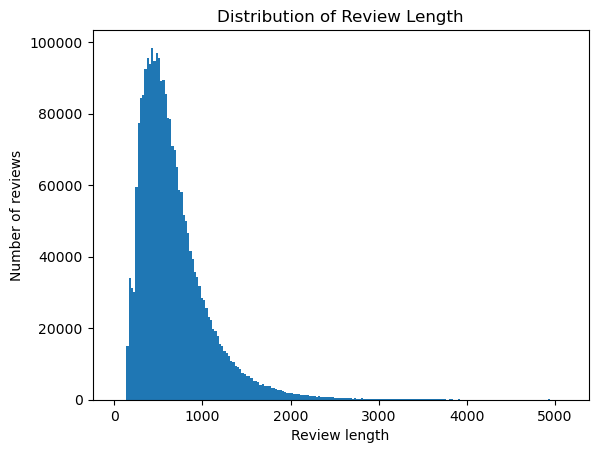

In [13]:
# Create a histogram of the review lengths using the 'text' column from the reviews_filt DataFrame.
plt.hist(reviews_filt['text'].str.len(), bins=200)

# Set x-axis and y-axis labels and the title.
plt.xlabel('Review length')
plt.ylabel('Number of reviews')
plt.title('Distribution of Review Length')

plt.show()


In [14]:
# Display descriptive statistics of the review lengths.
reviews_filt['text'].str.len().describe()

count    2.589584e+06
mean     6.765771e+02
std      4.082239e+02
min      7.000000e+00
25%      4.030000e+02
50%      5.800000e+02
75%      8.330000e+02
max      5.129000e+03
Name: text, dtype: float64

We attempted to improve consistency by **translating** all non-English textual reviews. To this end, we used the language detection module, $\texttt{detect}$, of the $\texttt{langdetect}$ library to **initially identify the language of each review**.

Due to the considerable computation time required for language detection, we decided to **keep the language identifier** of each review in a separate dataset, together with the **unique identifiers** of the **beer** and the **user**.

This approach allows us to store the language information in our archive, facilitating efficient access without the need to calculate the language detection for each review each time.

Note that whether exists in the repository the CSV file containing `user_id`, `beer_id` and `text_lang` (the language identifier of the reviews), we can avoid computation the information. Instead, we can merge the review dataset with this auxiliary dataset into a consolidated dataset, simplifying our analysis process.

In [15]:
data_name = 'reviews_lang.csv'
CODE_ERROR = 'Error'

if os.path.exists(data_name):
    reviews_language = pd.read_csv(data_name)
    reviews_filt = pd.merge(reviews_filt, reviews_language, on=['beer_id','user_id'], how='left')
else:
    # Detect the language of each review. Handle exception for non corrected reviews.
    text_lang = []
    for review in reviews_filt['text']:
        try:
            text_lang.append(detect(review))
        except:
            text_lang.append(CODE_ERROR)
            continue
    
    # Adding a new column 'text_lang' to store the detected language for each review
    reviews_filt['text_lang'] = pd.Series(text_lang)

    # Store the language information in a  
    reviews_filt[['beer_id', 'user_id', 'text_lang']].to_csv(data_name, index=False)

In [16]:
display(reviews_filt)

,beer_name,beer_id,brewery_name,brewery_id,style,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,text_lang
0,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,2008-04-09 10:00:00,Proteus93,proteus93.185128,4.0,4.5,4.5,4.5,4.0,4.37,"A: A deep amber, with a bit of a shorter head....",en
1,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,2008-04-07 10:00:00,Jerico,jerico.36192,4.0,4.0,3.0,3.0,3.5,3.40,Poured this into a Bordeaux wine glass.A - A p...,en
2,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,2008-04-06 10:00:00,armock,armock.159910,4.0,4.5,4.0,4.5,4.0,4.32,A - Poured a dark amber color with an of white...,en
3,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,2008-04-06 10:00:00,RickSawyer,ricksawyer.141904,3.5,4.5,4.0,4.0,4.5,4.19,"Pours ruby brown with a mahogany heart. Tight,...",en
4,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,2008-04-05 10:00:00,mattster,mattster.120835,4.0,4.0,4.0,4.5,4.5,4.30,"Opened 22 fluid ounce bomber bottle, poured in...",en
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2589579,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,2008-04-17 10:00:00,hyland24,hyland24.198789,4.5,4.5,4.0,4.5,4.5,4.45,Poured from a bomber into a pilsner glass. Dra...,en
2589580,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,2008-04-17 10:00:00,indiapaleale,indiapaleale.2781,4.5,4.0,4.0,4.5,4.0,4.23,Pours a nice dark mahogany color with a beauti...,en
2589581,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,2008-04-17 10:00:00,Moxley,moxley.205446,5.0,4.0,4.5,5.0,4.5,4.61,Enjoyed a nice 3-way tasting with fellow BA me...,en
2589582,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,2008-04-16 10:00:00,Pleepleus,pleepleus.211613,5.0,3.0,4.5,4.5,4.5,4.17,Enjoyed this Arrogant Bastard with fellow BA m...,NaN


In [17]:
print('The number of errors detected are:', np.sum(reviews_filt['text_lang'] ==CODE_ERROR))

The number of errors detected are: 0


In [18]:
print(f'The number of NaN values in text_lang colum is:', np.sum(reviews_filt['text_lang'].isna()), '/', len(reviews_filt['text_lang']))

The number of NaN values in text_lang colum is: 2 / 2589584


We then decide to drop the NaN values due to the small number of occurrences of NaN values in the `text_lang` column in our filtered reviews dataset.

In [19]:
reviews_filt = reviews_filt[reviews_filt['text_lang'].notna()]

In [20]:
print('The count and variety of distinct languages used in the reviews within our dataset:')
print(reviews_filt['text_lang'].value_counts())

The count and variety of distinct languages used in the reviews within our dataset:
en       2588992
fr           343
es            62
pt            45
fi            30
af            17
de            13
no            13
nl            10
et             9
ca             7
it             7
da             7
cs             6
so             5
tl             3
sv             2
zh-cn          2
ru             2
ro             1
sq             1
sk             1
id             1
hr             1
tr             1
pl             1
Name: text_lang, dtype: int64


In [21]:
"""
    Translates the input text to English.

    Parameters:
        text (str): The input text to be translated.
        source (str): The source language (default is 'auto' for automatic detection).
        target (str): The target language (default is 'en' for English).

    Returns:
        The translated text in English.
"""
def translate_to_english(text, source='auto', target='en'):
    translated = GoogleTranslator(source=source, target=target).translate(text)
    return translated

We then filter rows in the DataFrame where the `text_lang` column is not 'en', then apply translation to English for the corresponding 'text' column.

In [22]:
reviews_filt[reviews_filt.text_lang != 'en']['text'] = reviews_filt[reviews_filt.text_lang != 'en']['text'].apply(lambda x: translate_to_english(x))

C:\Users\dange\AppData\Local\Temp\ipykernel_20152\1963095262.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_filt[reviews_filt.text_lang != 'en']['text'] = reviews_filt[reviews_filt.text_lang != 'en']['text'].apply(lambda x: translate_to_english(x))


With all reviews now in **English**, we can proceed to remove the `text_lang` column.

In [23]:
reviews_filt = reviews_filt.drop(['text_lang'], axis=1)

We then undertook a more further analysis, focusing on the textual representation of reviews. We followed the following steps:

- **Management of special characters**: After examining the modified and translated dataset, we observed the presence of some special characters such as "\&quot;" and "\x92" in some reviews. To solve this problem, we used the html.unescape function to convert the HTML entities and then removed the non-ASCII characters by encoding them in ASCII and decoding them again.

- **Filtering short reviews**: As a final step, we filtered out reviews with less than 50 characters. This step aimed to exclude shorter reviews from our dataset, focusing on more substantial texts.

In [24]:
# Apply the 'unescape' function to decode HTML entities in the 'text' column
reviews_filt['text'] = reviews_filt['text'].apply(unescape)

# Remove non-ASCII characters by encoding to ASCII and decoding back
reviews_filt['text'] = reviews_filt['text'].apply(lambda x: x.encode('ascii', 'ignore').decode())

# Set the minimum number of characters for reviews
MIN_NUMBER_OF_CHARACTER = 50

# Filter out reviews with fewer than 'min_character' characters
reviews_filt = reviews_filt[reviews_filt['text'].str.len() > MIN_NUMBER_OF_CHARACTER]

In [25]:
display(reviews_filt)

,beer_name,beer_id,brewery_name,brewery_id,style,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text
0,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,2008-04-09 10:00:00,Proteus93,proteus93.185128,4.0,4.5,4.5,4.5,4.0,4.37,"A: A deep amber, with a bit of a shorter head...."
1,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,2008-04-07 10:00:00,Jerico,jerico.36192,4.0,4.0,3.0,3.0,3.5,3.40,Poured this into a Bordeaux wine glass.A - A p...
2,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,2008-04-06 10:00:00,armock,armock.159910,4.0,4.5,4.0,4.5,4.0,4.32,A - Poured a dark amber color with an of white...
3,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,2008-04-06 10:00:00,RickSawyer,ricksawyer.141904,3.5,4.5,4.0,4.0,4.5,4.19,"Pours ruby brown with a mahogany heart. Tight,..."
4,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,2008-04-05 10:00:00,mattster,mattster.120835,4.0,4.0,4.0,4.5,4.5,4.30,"Opened 22 fluid ounce bomber bottle, poured in..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2589577,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,2008-04-21 10:00:00,nasty15108,nasty15108.188801,4.0,4.0,4.0,4.0,4.0,4.00,Poured form a 1pt 6oz bottle into a pint glass...
2589578,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,2008-04-19 10:00:00,Offa,offa.193015,4.5,4.5,4.0,4.5,4.5,4.45,"This is a nicely strong, slightly rough but de..."
2589579,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,2008-04-17 10:00:00,hyland24,hyland24.198789,4.5,4.5,4.0,4.5,4.5,4.45,Poured from a bomber into a pilsner glass. Dra...
2589580,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,2008-04-17 10:00:00,indiapaleale,indiapaleale.2781,4.5,4.0,4.0,4.5,4.0,4.23,Pours a nice dark mahogany color with a beauti...


## MERGE

Only as test 

In [34]:
reviews_aug = pd.merge(reviews_filt, users_filt, on=['user_id','user_name'], how='inner')
display(reviews_aug)

,beer_name,beer_id,brewery_name,brewery_id,style,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,nbr_ratings,nbr_reviews,joined,user_location
0,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,2008-04-09 10:00:00,Proteus93,proteus93.185128,4.0,4.5,4.5,4.5,4.0,4.37,"A: A deep amber, with a bit of a shorter head....",1010,1010,2008-01-08 11:00:00,"United States, Virginia"
1,Double Bastard Ale,1056,Arrogant Brewing,43153,American Strong Ale,2008-05-22 10:00:00,Proteus93,proteus93.185128,4.5,4.5,5.0,4.5,4.5,4.55,A: Poured into a standard Stone pintglass. A d...,1010,1010,2008-01-08 11:00:00,"United States, Virginia"
2,OAKED Arrogant Bastard Ale,8951,Arrogant Brewing,43153,American Strong Ale,2008-01-26 11:00:00,Proteus93,proteus93.185128,5.0,4.0,4.5,4.5,4.5,4.41,"A: A deep brown pour, some red highlights. Bea...",1010,1010,2008-01-08 11:00:00,"United States, Virginia"
3,Trader Joe's 2012 Vintage Ale,86743,Trader Joe's Brewing Company,10707,Belgian Strong Dark Ale,2012-11-17 11:00:00,Proteus93,proteus93.185128,4.0,4.0,4.0,3.5,3.5,3.70,So we just had a Trader Joe's open up in Charl...,1010,1010,2008-01-08 11:00:00,"United States, Virginia"
4,Le Merle,37112,North Coast Brewing Co.,112,Saison / Farmhouse Ale,2009-01-19 11:00:00,Proteus93,proteus93.185128,4.0,3.5,4.5,4.0,4.0,3.93,"Served on tap at Beer Run in Charlottesville, ...",1010,1010,2008-01-08 11:00:00,"United States, Virginia"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2494468,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,2009-06-02 10:00:00,GWEBB9,gwebb9.166159,4.5,5.0,5.0,4.5,5.0,4.77,This is a great beer. Always go back to this o...,1,1,2007-10-20 10:00:00,"United States, Maryland"
2494469,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,2009-04-16 10:00:00,norsktorsk,norsktorsk.319436,4.0,5.0,4.0,4.5,4.5,4.54,Its the start of the Stanley Cup Playoffs an I...,2,1,2009-04-13 10:00:00,"United States, New York"
2494470,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,2009-03-04 11:00:00,benjilek,benjilek.300077,4.5,3.5,4.5,4.0,4.0,3.96,This was an exceptional beer. Very unique. It ...,1,1,2009-02-18 11:00:00,"United States, Maryland"
2494471,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,2008-12-21 11:00:00,DunDun,dundun.272883,5.0,4.5,4.5,5.0,5.0,4.83,This is my first review and I just had to say ...,1,1,2008-12-02 11:00:00,"United States, Ohio"


In [35]:
df_RBU = pd.merge(reviews_aug, breweries_filt, on=['brewery_id','brewery_name'], how='inner')
display(df_RBU)
print('Number of NaN by category:')
print(df_RBU.isna().sum())

,beer_name,beer_id,brewery_name,brewery_id,style,date,user_name,user_id,appearance,aroma,...,taste,overall,rating,text,nbr_ratings,nbr_reviews,joined,user_location,brewery_location,nbr_beers
0,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,2008-04-09 10:00:00,Proteus93,proteus93.185128,4.0,4.5,...,4.5,4.0,4.37,"A: A deep amber, with a bit of a shorter head....",1010,1010,2008-01-08 11:00:00,"United States, Virginia","United States, California",41
1,Double Bastard Ale,1056,Arrogant Brewing,43153,American Strong Ale,2008-05-22 10:00:00,Proteus93,proteus93.185128,4.5,4.5,...,4.5,4.5,4.55,A: Poured into a standard Stone pintglass. A d...,1010,1010,2008-01-08 11:00:00,"United States, Virginia","United States, California",41
2,OAKED Arrogant Bastard Ale,8951,Arrogant Brewing,43153,American Strong Ale,2008-01-26 11:00:00,Proteus93,proteus93.185128,5.0,4.0,...,4.5,4.5,4.41,"A: A deep brown pour, some red highlights. Bea...",1010,1010,2008-01-08 11:00:00,"United States, Virginia","United States, California",41
3,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,2008-04-07 10:00:00,Jerico,jerico.36192,4.0,4.0,...,3.0,3.5,3.40,Poured this into a Bordeaux wine glass.A - A p...,47,47,2005-08-23 10:00:00,"United States, New York","United States, California",41
4,Arrogant Bastard Ale,92,Arrogant Brewing,43153,American Strong Ale,2008-04-06 10:00:00,armock,armock.159910,4.0,4.5,...,4.5,4.0,4.32,A - Poured a dark amber color with an of white...,1409,1256,2007-09-21 10:00:00,"United States, New York","United States, California",41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2344228,La Porteña Stout,273430,La Porteña Cervecería Artesanal,48642,American Stout,2017-03-23 11:00:00,Short_And_Stout,short_and_stout.1194173,4.0,3.5,...,4.0,3.75,3.76,"Look: dark brown, hints of red when held up to...",1,1,2017-03-15 11:00:00,"United States, Pennsylvania",Nicaragua,1
2344229,Public Static Lemongrass IPA,156860,Nerdbrewing,38748,American IPA,2015-02-08 11:00:00,kazin,kazin.236728,3.75,4.5,...,4.5,4.25,4.36,Sampled from bottle. Very cloudy appearance bu...,23,6,2008-07-23 10:00:00,Sweden,Sweden,4
2344230,R34 Porter,131988,Kozy Yak Brewery,33346,American Porter,2014-08-03 10:00:00,WalterDragon,walterdragon.838867,3.0,2.0,...,1.0,1.25,1.51,"Thought I would try a small, local brew pub. T...",16,2,2014-08-03 10:00:00,"United States, Wisconsin","United States, Wisconsin",9
2344231,Can't Hook Kolsch,258870,Sawmill Brewing Company,44767,Kölsch,2017-02-27 11:00:00,Gully13,gully13.1192412,4.25,4.5,...,5.0,4.5,4.69,Poured from a growlerOverall a great take on t...,4,3,2017-02-27 11:00:00,"United States, North Carolina","United States, Wisconsin",11


Number of NaN by category:
beer_name           0
beer_id             0
brewery_name        0
brewery_id          0
style               0
date                0
user_name           0
user_id             0
appearance          0
aroma               0
palate              0
taste               0
overall             0
rating              0
text                0
nbr_ratings         0
nbr_reviews         0
joined              0
user_location       0
brewery_location    0
nbr_beers           0
dtype: int64


## CODE USED TO SPLIT reviews.txt etc.

In [ ]:
row_count = 0

# Open the file and count the lines
with open(Reviews_DATASET, 'r', encoding='utf-8') as file:
    for line in file:
        row_count += 1

print(f'Number of rows in the file: {row_count}')

In [ ]:
lines_per_file = 2316998
smallfile = None
with open(Reviews_DATASET, 'r', encoding='utf-8') as bigfile:
    for lineno, line in enumerate(bigfile):
        if lineno % lines_per_file == 0:
            if smallfile:
                smallfile.close()
            small_filename = '../DATA/BeerAdvocate/reviews/small_file_{}.txt'.format(lineno + lines_per_file)
            smallfile = open(small_filename, "w", encoding='utf-8')
        smallfile.write(line)
    if smallfile:
        smallfile.close()

In [ ]:
directory = DATA_FOLDER_BA + 'reviews/'
reviews = pd.DataFrame()
for filename in os.listdir(directory):
    # Initialize empty lists to store the extracted data
    beer_data = []
    current_review = {}  # Initialize an empty dictionary to store the current review
    # Open the text file and read it line by line
    with open(directory + filename, 'r', encoding='utf-8') as file:

        for line in file:
            line = line.strip()  # Remove leading/trailing whitespace
            if line:  # If the line is not empty
                key, value = line.split(":",1)
                current_review[key] = value
            else:  # Blank line indicates the end of a review
                if current_review:
                    beer_data.append(current_review)
                current_review = {}  # Reset the dictionary for the next review

    # If there's any remaining review, add it to the list
    if current_review:
        beer_data.append(current_review)

    # Convert the list of dictionaries into a Pandas DataFrame
    reviews_tmp = pd.DataFrame(beer_data)
    reviews = pd.concat([reviews,reviews_tmp])


display(reviews)

In [ ]:
lines_per_file = 2316998
smallfile = None
with open(Reviews_DATASET, 'r', encoding='utf-8') as bigfile:
    for lineno, line in enumerate(bigfile):
        if lineno % lines_per_file == 0:
            if smallfile:
                smallfile.close()
            small_filename = '../DATA/BeerAdvocate/reviews/small_file_{}.txt'.format(lineno + lines_per_file)
            smallfile = open(small_filename, "w", encoding='utf-8')
        smallfile.write(line)
    if smallfile:
        smallfile.close()

In [ ]:
filename_review = DATA_FOLDER_BA + 'reviews_BA.csv'
reviews.to_csv(filename_review, encoding='utf-8', index=False)